# Processing text queries
- code in this notebook predominantly analyze text queries submitted by participants to solve KIS tasks of VBS 2023
- among others, this notebook can replicate the content of Table 2 and 3 as well as Figures 13-15

In [65]:
import sys
import os
modules_path = os.getcwd() + '/src/python'
sys.path.insert(0, modules_path)

# imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
from notebooks.utils import compute_user_penalty, get_team_values_df
from common.load import load_competition_data, process_team_logs

pd.set_option('display.max_colwidth', None)
unknownRankLimit = 1000
unknownRankValue = 2000

# Import common data

In [66]:
config = modules_path +'/config_vbs2023.yaml'

# load competition data from dres files and auxiliary data (FPSs, sequences)
comp_data = load_competition_data(config)

# load the preprocessed query data
dataset = pd.read_pickle(comp_data["config"]["processed_logs_outdir"] + '/text_query_dataset.pkl')

# valid teams
team_order = ['vibro', 'VISIONE',  'vitrivr-VR', 'CVHunter', 'Verge']
#team_order = ['vibro', 'VISIONE', 'VIREO' 'vitrivr-VR', 'CVHunter', 'vitrivr', 'Verge']

dataset.shape

/home/lucia/dev/python/VBS23-Post-Hoc-Analysis/src/python/common/tasks.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.tasks_df = self.tasks_df.append({
/home/lucia/dev/python/VBS23-Post-Hoc-Analysis/src/python/common/tasks.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.tasks_df = self.tasks_df.append({
/home/lucia/dev/python/VBS23-Post-Hoc-Analysis/src/python/common/tasks.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.tasks_df = self.tasks_df.append({
/home/lucia/dev/python/VBS23-Post-Hoc-Analysis/src/python/common/tasks.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.tasks_df = self.tasks_df.a

(782, 20)

### Creating auxiliary variables
- Query length and volume of words per query
- Maybe also store information whether the query is temporal? Only HTW and VISIONE have obviouse temporal queries
- Define visual vs textual tasks

In [67]:
dataset["task_type"] = "visual"
dataset.loc[dataset.task.str.contains("kis-t"),"task_type"] = "textual"

dataset["query_type"] = "Other"
dataset.loc[(dataset.is_joint_embedding_text_query) &  ~(dataset.is_temporal_query), "query_type"] = "Text"
dataset.loc[(dataset.is_joint_embedding_text_query) &  (dataset.is_temporal_query), "query_type"] = "Text + Temporal"

dataset["QueryLen"] = -1
dataset["QueryWords"] = -1

dataset.loc[dataset["query_type"]=="Text","QueryLen"] = dataset.loc[dataset["query_type"]=="Text","value"].str.len()
dataset.loc[dataset["query_type"]=="Text","QueryWords"] = dataset.loc[dataset["query_type"]=="Text","value"].str.split().str.len()
dataset.loc[dataset["query_type"]=="Text + Temporal","QueryLen"] = dataset.loc[dataset["query_type"]=="Text + Temporal","value"].str.len()
dataset.loc[dataset["query_type"]=="Text + Temporal","QueryWords"] = dataset.loc[dataset["query_type"]=="Text + Temporal","value"].str.split().str.len()

dataset['user'] = dataset['user'].replace(0, '1st').replace(1, '2nd')

dataset.head()

,level_0,index,task,team,user,timestamp,elapsed_since_task_start_ms,correct_submission_time_ms,rank_video,rank_shot_margin_0,...,value,additionals,is_user_with_correct_submission,is_temporal_query,is_joint_embedding_text_query,joint_text_embedding,task_type,query_type,QueryLen,QueryWords
0,0,0,vbs23-kis-v1,vibro,1st,1673259650000,36687,43981.0,1.0,1.0,...,Man in pink closest standing a basketball stadium,{},NaN,False,True,"[123, 124, -125, -112, -124, -116, -121, 122, -109, 125, -117, -123, 124, -122, 126, -122, -127, 127, 121, -125, 122, -121, 124, 121, -116, 127, -126, -126, -126, 127, 124, -123, 123, -123, -126, 126, 118, 115, 126, -127, 125, 116, 127, 122, 125, -128, 124, -123, -128, -126, -123, 127, -115, -128, -119, 117, -125, 114, 125, -124, -128, -125, 112, 127, 125, 117, 121, -122, -120, -127, 123, 124, 124, 120, 123, 127, -123, 115, 121, 123, -127, -124, 111, 123, 123, -125, 124, 119, -126, 120, -128, -126, -125, 122, 119, 125, 125, 126, -124, -122, ...]",visual,Text,49,8
166,166,166,vbs23-kis-v6,vibro,2nd,1673279166000,278891,NaN,177.0,665.0,...,paraglider starting flying over mountains with sun and clouds in the background,{},NaN,False,True,"[123, 121, -125, 111, 125, -120, -117, -124, -115, 125, 118, 121, -128, -126, 125, -125, -118, -119, 119, 122, -124, -124, 120, -122, -126, 123, 119, 124, 116, 112, 122, -119, 125, 125, -122, -117, 127, 118, -128, 126, -128, -128, -128, 121, -125, 127, -127, 122, -123, 114, 121, 120, 116, -125, 120, 115, -125, -125, -122, 117, -120, -118, 102, -116, 126, -127, -122, 116, 123, -126, 123, 126, 124, -124, -117, -116, -124, 118, 125, -121, -122, 117, -115, -127, -122, 124, 119, -123, 125, -125, -128, -127, 124, 116, 123, 124, -127, 126, -124, -124, ...]",visual,Text,79,12
165,165,165,vbs23-kis-v6,vibro,2nd,1673279134000,246891,NaN,44.0,inf,...,video 06651 at 00:02:18.000 (Frame #4135),{},NaN,False,False,None,visual,Other,-1,-1
71,71,71,vbs23-kis-v6,vibro,1st,1673279070000,182891,NaN,427.0,inf,...,video 08379 at 00:02:24.000 (Frame #4315),{},NaN,False,False,None,visual,Other,-1,-1
164,164,164,vbs23-kis-v6,vibro,2nd,1673279113000,225891,NaN,246.0,271.0,...,video 07660 at 00:01:38.000 (Frame #2937),{},NaN,False,False,None,visual,Other,-1,-1


In [68]:
dataset.loc[(dataset['is_joint_embedding_text_query'] == False) & (dataset['team'] == 'VISIONE'), ["team", "category", "type", "query_type", "timestamp"]]

,team,category,type,query_type,timestamp
168,VISIONE,Other,LocalizedObjectAndColors > classes,Other,1673272765946
180,VISIONE,IMAGE,globalFeatures > sematic video similarity (CLIP),Other,1673276066338
174,VISIONE,IMAGE,globalFeatures > image similarity (GEM),Other,1673273158977
167,VISIONE,Other,LocalizedObjectAndColors > position,Other,1673272765946
165,VISIONE,IMAGE,globalFeatures > image similarity (GEM),Other,1673272617730
164,VISIONE,IMAGE,globalFeatures > image similarity (GEM),Other,1673272478207


# Table 2 in the paper: usage of Text queries

In [69]:
# percentage of how many rows per team belong to a text query and an image query
counts = dataset.groupby(["team","query_type"])[["value"]].count()
counts = ((counts / counts.groupby('team')[["value"]].sum())*100).round(1)

# add empty rows
counts = counts.reset_index()
counts = counts.append(pd.DataFrame([{'team': 'vitrivr-VR', 'query_type': 'Other', 'value': 0}], columns=counts.columns))

# sort in team order
counts = counts.set_index(['team','query_type']).loc[team_order, :]
counts

/tmp/ipykernel_28707/1618529372.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  counts = counts.append(pd.DataFrame([{'team': 'vitrivr-VR', 'query_type': 'Other', 'value': 0}], columns=counts.columns))


value
team       query_type            
vibro      Other             46.6
           Text              46.6
           Text + Temporal    6.8
VISIONE    Other              3.7
           Text              58.3
           Text + Temporal   38.0
vitrivr-VR Text              94.5
           Text + Temporal    5.5
           Other              0.0
CVHunter   Other             35.5
           Text              54.4
           Text + Temporal   10.1
Verge      Other             11.7
           Text              88.3

In [70]:
print(counts.to_latex())

\begin{tabular}{llr}
\toprule
      &      &  value \\
team & query\_type &        \\
\midrule
vibro & Other &   46.6 \\
      & Text &   46.6 \\
      & Text + Temporal &    6.8 \\
VISIONE & Other &    3.7 \\
      & Text &   58.3 \\
      & Text + Temporal &   38.0 \\
vitrivr-VR & Text &   94.5 \\
      & Text + Temporal &    5.5 \\
      & Other &    0.0 \\
CVHunter & Other &   35.5 \\
      & Text &   54.4 \\
      & Text + Temporal &   10.1 \\
Verge & Other &   11.7 \\
      & Text &   88.3 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_28707/1484047370.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(counts.to_latex())


In [71]:
queryCount = dataset.groupby(["team", "user", "query_type", "timestamp"])['task'].count().reset_index()
queryCount = queryCount.groupby(["team", "user", "query_type"]).count()
queryCount = queryCount['task']
queryCount

team        user  query_type     
CVHunter    1st   Other               28
                  Text                54
                  Text + Temporal     22
            2nd   Other               53
                  Text                70
                  Text + Temporal      1
VISIONE     1st   Text                37
                  Text + Temporal     10
            2nd   Other                5
                  Text                58
                  Text + Temporal     52
Verge       1st   Other               18
                  Text               109
vibro       1st   Other               37
                  Text                34
                  Text + Temporal      3
            2nd   Other               38
                  Text                41
                  Text + Temporal      8
vitrivr-VR  1st   Text                54
                  Text + Temporal      2
            2nd   Text                32
                  Text + Temporal      3
Name: task, dtype: int6

In [72]:
queryCount.groupby(["team", "user"]).sum()

team        user
CVHunter    1st     104
            2nd     124
VISIONE     1st      47
            2nd     115
Verge       1st     127
vibro       1st      74
            2nd      87
vitrivr-VR  1st      56
            2nd      35
Name: task, dtype: int64

In [73]:
((queryCount / queryCount.groupby(["team", "user"]).sum())*100).round(1)

team        user  query_type     
CVHunter    1st   Other              26.9
                  Text               51.9
                  Text + Temporal    21.2
            2nd   Other              42.7
                  Text               56.5
                  Text + Temporal     0.8
VISIONE     1st   Text               78.7
                  Text + Temporal    21.3
            2nd   Other               4.3
                  Text               50.4
                  Text + Temporal    45.2
Verge       1st   Other              14.2
                  Text               85.8
vibro       1st   Other              50.0
                  Text               45.9
                  Text + Temporal     4.1
            2nd   Other              43.7
                  Text               47.1
                  Text + Temporal     9.2
vitrivr-VR  1st   Text               96.4
                  Text + Temporal     3.6
            2nd   Text               91.4
                  Text + Temporal     8.6


# Table 3

In [74]:
# median values
dataset.loc[dataset.rank_video > unknownRankLimit, "rank_video"] = unknownRankValue
dataset.loc[dataset.rank_shot_margin_0 > unknownRankLimit, "rank_shot_margin_0"] = unknownRankValue
dataset.loc[dataset.rank_shot_margin_5 > unknownRankLimit, "rank_shot_margin_5"] = unknownRankValue
medianStats = dataset.groupby(["team","user","query_type"])[["rank_shot_margin_0","rank_shot_margin_5","rank_video"]].median()

# mean query length and word count
meanQueryStats = dataset.groupby(["team","user","query_type"])[["QueryWords","QueryLen"]].mean()

# query count per team, user and query_type
queryCount = dataset.groupby(["team", "user", "query_type", "timestamp"])['task'].count().reset_index()
queryCount = queryCount.groupby(["team", "user", "query_type"]).count()
queryCount = queryCount['task']
#queryUsage = ((queryCount / dataset.groupby(["team", "user"])['task'].count())*100).round(1)
queryUsage = ((queryCount / queryCount.groupby(["team", "user"]).sum())*100).round(1)

# construct table
restrData = dataset
top5 = restrData.loc[restrData.rank_shot_margin_0 < 5].groupby(["team","user","query_type"]).count()["rank_shot_margin_0"]
top10 = restrData.loc[restrData.rank_shot_margin_0 < 10].groupby(["team","user","query_type"]).count()["rank_shot_margin_0"]
top20 = restrData.loc[restrData.rank_shot_margin_0 < 20].groupby(["team","user","query_type"]).count()["rank_shot_margin_0"]
top50 = restrData.loc[restrData.rank_shot_margin_0 < 50].groupby(["team","user","query_type"]).count()["rank_shot_margin_0"]
top100 = restrData.loc[restrData.rank_shot_margin_0 < 100].groupby(["team","user","query_type"]).count()["rank_shot_margin_0"]
top200 = restrData.loc[restrData.rank_shot_margin_0 < 200].groupby(["team","user","query_type"]).count()["rank_shot_margin_0"]
top500 = restrData.loc[restrData.rank_shot_margin_0 < 500].groupby(["team","user","query_type"]).count()["rank_shot_margin_0"]

resTab1 = pd.DataFrame({"total queries":queryCount,
                        "queries usage":queryUsage,
                        "words / query": 0,
                        "query length": 0,
                        "top5":(top5/queryCount*100).round(1),
                        "top10":(top10/queryCount*100).round(1),
                        "top20":(top20/queryCount*100).round(1),
                        "top50":(top50/queryCount*100).round(1),
                        "top100":(top100/queryCount*100).round(1),
                        "top200":(top200/queryCount*100).round(1),
                        "top500":(top500/queryCount*100).round(1)}).fillna(0)

# in the end we want mean stats
resTab1["words / query"] = meanQueryStats["QueryWords"]
resTab1["query length"] = meanQueryStats["QueryLen"]

# sort in team order
resTab1 = resTab1.loc[team_order, :]
resTab1

total queries  queries usage  words / query  \
team       user query_type                                                     
vibro      1st  Other                       37           50.0      -1.000000   
                Text                        34           45.9       9.676471   
                Text + Temporal              3            4.1      13.000000   
           2nd  Other                       38           43.7      -1.000000   
                Text                        41           47.1       7.000000   
                Text + Temporal              8            9.2       8.000000   
VISIONE    1st  Text                        37           78.7      17.135135   
                Text + Temporal             10           21.3      32.800000   
           2nd  Other                        5            4.3      -1.000000   
                Text                        58           50.4      10.344828   
                Text + Temporal             52           45.2      19.615385   
vitrivr-VR 1st  Text                        54           96.4       7.055556   
                Text + Temporal              2            3.6      14.500000   
           2nd  Text                        32           91.4       5.250000   
                Text + Temporal              3            8.6       8.000000   
CVHunter   1st  Other                       28           26.9      -1.000000   
                Text                        54           51.9      10.388889   
                Text + Temporal             22           21.2      15.181818   
           2nd  Other                       53           42.7      -1.000000   
                Text                        70           56.5       6.971429   
                Text + Temporal              1            0.8       9.000000   
Verge      1st  Other                       18           14.2      -1.000000   
                Text                       109           85.8       4.966942   

                                 query length  top5  top10  top20  top50  \
team       user query_type                                                 
vibro      1st  Other               -1.000000   2.7    5.4   13.5   27.0   
                Text                51.029412  11.8   14.7   17.6   29.4   
                Text + Temporal     61.000000   0.0    0.0   66.7  100.0   
           2nd  Other               -1.000000   2.6    2.6   10.5   21.1   
                Text                37.341463   7.3   12.2   22.0   29.3   
                Text + Temporal     43.000000   0.0    0.0    0.0    0.0   
VISIONE    1st  Text                87.945946  10.8   10.8   13.5   24.3   
                Text + Temporal    173.900000  10.0   10.0   30.0   60.0   
           2nd  Other               -1.000000  20.0   20.0   20.0   40.0   
                Text                52.862069   6.9   10.3   17.2   22.4   
                Text + Temporal     98.596154  11.5   13.5   17.3   25.0   
vitrivr-VR 1st  Text                34.925926   3.7    7.4   13.0   14.8   
                Text + Temporal     78.500000   0.0    0.0    0.0    0.0   
           2nd  Text                27.937500   0.0    3.1    3.1    3.1   
                Text + Temporal     40.000000   0.0    0.0    0.0    0.0   
CVHunter   1st  Other               -1.000000  10.7   10.7   10.7   14.3   
                Text                57.444444   0.0   11.1   11.1   13.0   
                Text + Temporal     79.681818  13.6   31.8   36.4   40.9   
           2nd  Other               -1.000000   1.9    1.9    7.5   13.2   
                Text                40.642857   4.3    4.3    5.7    8.6   
                Text + Temporal     46.000000   0.0    0.0    0.0    0.0   
Verge      1st  Other               -1.000000   5.6   11.1   11.1   11.1   
                Text                28.272727   0.9    0.9    1.8    3.7   

                                 top100  top200  top500  
team       user query_type                               
vibro      1st 

## add queries per minute to table 3

In [75]:
# total availabe time to ask queries per team
totTime = dataset.groupby(["team", "task"])[["correct_submission_time_ms"]].min().reset_index().groupby(["team"])["correct_submission_time_ms"].sum()

# query per minute per user, team and query type
queryPerMinute = queryCount/totTime*1000*60
qpmdf = pd.DataFrame({"QPM": queryPerMinute})

# table 3
tab3 = resTab1.reset_index().set_index(['team', 'user', 'query_type'])

# copy queries per minute column for all clip rows
tab3["query / minute"] = qpmdf["QPM"]

# Replace NaN values with zeros
tab3 = tab3.fillna(0)
                   
# Replace -1 with 0
tab3 = tab3.replace(-1, 0)

# combine query count and usage columns
tab3["usage"] = tab3["total queries"].astype(str) + ' (' + tab3["queries usage"].astype(int).astype(str) + '%)'
                   
tab3[["usage", "query / minute","words / query","query length","top10","top20","top50","top100","top200"]].round(2)

usage  query / minute  words / query  \
team       user query_type                                                  
vibro      1st  Other             37 (50%)            1.39           0.00   
                Text              34 (45%)            1.28           9.68   
                Text + Temporal     3 (4%)            0.11          13.00   
           2nd  Other             38 (43%)            1.43           0.00   
                Text              41 (47%)            1.54           7.00   
                Text + Temporal     8 (9%)            0.30           8.00   
VISIONE    1st  Text              37 (78%)            1.49          17.14   
                Text + Temporal   10 (21%)            0.40          32.80   
           2nd  Other               5 (4%)            0.20           0.00   
                Text              58 (50%)            2.34          10.34   
                Text + Temporal   52 (45%)            2.10          19.62   
vitrivr-VR 1st  Text              54 (96%)            1.73           7.06   
                Text + Temporal     2 (3%)            0.06          14.50   
           2nd  Text              32 (91%)            1.03           5.25   
                Text + Temporal     3 (8%)            0.10           8.00   
CVHunter   1st  Other             28 (26%)            1.39           0.00   
                Text              54 (51%)            2.68          10.39   
                Text + Temporal   22 (21%)            1.09          15.18   
           2nd  Other             53 (42%)            2.63           0.00   
                Text              70 (56%)            3.48           6.97   
                Text + Temporal     1 (0%)            0.05           9.00   
Verge      1st  Other             18 (14%)            0.64           0.00   
                Text             109 (85%)            3.90           4.97   

                                 query length  top10  top20  top50  top100  \
team       user query_type                                                   
vibro      1st  Other                    0.00    5.4   13.5   27.0    35.1   
                Text                    51.03   14.7   17.6   29.4    35.3   
                Text + Temporal         61.00    0.0   66.7  100.0   100.0   
           2nd  Other                    0.00    2.6   10.5   21.1    28.9   
                Text                    37.34   12.2   22.0   29.3    34.1   
                Text + Temporal         43.00    0.0    0.0    0.0     0.0   
VISIONE    1st  Text                    87.95   10.8   13.5   24.3    29.7   
                Text + Temporal        173.90   10.0   30.0   60.0    80.0   
           2nd  Other                    0.00   20.0   20.0   40.0    40.0   
                Text                    52.86   10.3   17.2   22.4    25.9   
                Text + Temporal         98.60   13.5   17.3   25.0    30.8   
vitrivr-VR 1st  Text                    34.93    7.4   13.0   14.8    18.5   
                Text + Temporal         78.50    0.0    0.0    0.0     0.0   
           2nd  Text                    27.94    3.1    3.1    3.1     3.1   
                Text + Temporal         40.00    0.0    0.0    0.0     0.0   
CVHunter   1st  Other                    0.00   10.7   10.7   14.3    25.0   
                Text                    57.44   11.1   11.1   13.0    20.4   
                Text + Temporal         79.68   31.8   36.4   40.9    45.5   
           2nd  Other                    0.00    1.9    7.5   13.2    18.9   
                Text                    40.64    4.3    5.7    8.6    12.9   
                Text + Temporal         46.00    0.0    0.0    0.0     0.0   
Verge      1st  Other                    0.00   11.1   11.1   11.1    16.7   
                Text                    28.27    0.9    1.8    3.7     5.5   

                                 top200  
team       user query_type               
vibro      1st  Other              37.8  
                Text              

## create empty rows to table 3

In [76]:
from itertools import product

# Get unique values from each column
utab = tab3.reset_index()
unique_teams = utab['team'].unique()
unique_users = utab['user'].unique()
unique_query_types = utab['query_type'].unique()

# Generate all combinations
combinations = product(unique_teams, unique_users, unique_query_types)

# Create a new DataFrame from combinations
new_data = list(combinations)
new_df = pd.DataFrame(new_data, columns=['team', 'user', 'query_type'])

# Remove Verge second user
new_df = new_df[~((new_df['team'] == "Verge") & (new_df['user'] == "2nd"))]
new_df

,team,user,query_type
0,vibro,1st,Other
1,vibro,1st,Text
2,vibro,1st,Text + Temporal
3,vibro,2nd,Other
4,vibro,2nd,Text
5,vibro,2nd,Text + Temporal
6,VISIONE,1st,Other
7,VISIONE,1st,Text
8,VISIONE,1st,Text + Temporal
9,VISIONE,2nd,Other


In [77]:
tab3full = new_df.set_index(['team', 'user', 'query_type'])

# Copy specific columns from df to new_df
columns_to_copy = ["usage", "query / minute","words / query","query length","top10","top20","top50","top100","top200"]
tab3full[columns_to_copy] = tab3[columns_to_copy]

# Replace NaN values with zeros
tab3full = tab3full.fillna(0)

# round
tab3full = tab3full.round(2)

# order
tab3full = tab3full.sort_values(by=['team', 'user', 'query_type'], ascending=[True, True, False]).loc[team_order, :]

# rename verge first user to first + second user
tab3full = tab3full.reset_index()
tab3full.loc[tab3full["team"] == "Verge", "user"] = "1st & 2nd"
tab3full = tab3full.set_index(['team', 'user', 'query_type'])

# add a percentage sign
columns_to_convert = ['top10', 'top20', 'top50', 'top100', 'top200']
tab3full[columns_to_convert] = tab3full[columns_to_convert].astype(str) + '%'

# replace 0 with -
tab3full = tab3full.replace(0, '-')
tab3full = tab3full.replace("0.0%", '-')

tab3full

usage query / minute words / query  \
team       user      query_type                                                
vibro      1st       Text + Temporal     3 (4%)           0.11          13.0   
                     Text              34 (45%)           1.28          9.68   
                     Other             37 (50%)           1.39             -   
           2nd       Text + Temporal     8 (9%)            0.3           8.0   
                     Text              41 (47%)           1.54           7.0   
                     Other             38 (43%)           1.43             -   
VISIONE    1st       Text + Temporal   10 (21%)            0.4          32.8   
                     Text              37 (78%)           1.49         17.14   
                     Other                    -              -             -   
           2nd       Text + Temporal   52 (45%)            2.1         19.62   
                     Text              58 (50%)           2.34         10.34   
                     Other               5 (4%)            0.2             -   
vitrivr-VR 1st       Text + Temporal     2 (3%)           0.06          14.5   
                     Text              54 (96%)           1.73          7.06   
                     Other                    -              -             -   
           2nd       Text + Temporal     3 (8%)            0.1           8.0   
                     Text              32 (91%)           1.03          5.25   
                     Other                    -              -             -   
CVHunter   1st       Text + Temporal   22 (21%)           1.09         15.18   
                     Text              54 (51%)           2.68         10.39   
                     Other             28 (26%)           1.39             -   
           2nd       Text + Temporal     1 (0%)           0.05           9.0   
                     Text              70 (56%)           3.48          6.97   
                     Other             53 (42%)           2.63             -   
Verge      1st & 2nd Text + Temporal          -              -             -   
                     Text             109 (85%)            3.9          4.97   
                     Other             18 (14%)           0.64             -   

                                     query length  top10  top20   top50  \
team       user      query_type                                           
vibro      1st       Text + Temporal         61.0      -  66.7%  100.0%   
                     Text                   51.03  14.7%  17.6%   29.4%   
                     Other                      -   5.4%  13.5%   27.0%   
           2nd       Text + Temporal         43.0      -      -       -   
                     Text                   37.34  12.2%  22.0%   29.3%   
                     Other                      -   2.6%  10.5%   21.1%   
VISIONE    1st       Text + Temporal        173.9  10.0%  30.0%   60.0%   
                     Text                   87.95  10.8%  13.5%   24.3%   
                     Other                      -      -      -       -   
           2nd       Text + Temporal         98.6  13.5%  17.3%   25.0%   
                     Text                   52.86  10.3%  17.2%   22.4%   
                     Other                      -  20.0%  20.0%   40.0%   
vitrivr-VR 1st       Text + Temporal         78.5      -      -       -   
                     Text                   34.93   7.4%  13.0%   14.8%   
                     Other                      -      -      -       -   
           2nd       Text + Temporal         40.0      -      -       -   
                     Text                   27.94   3.1%   3.1%    3.1%   
                     Other                      -      -      -       -   
CVHunter   1st       Text + Temporal        79.68  31.8%  36.4%   40.9%   
                     Text                   57.44  11.1%  11.1%   13.0%   
                     Other                      -  10.7%  10.7%   14.3%

In [78]:
print(tab3full.to_latex())

\begin{tabular}{llllllllllll}
\toprule
      &           &       &      usage & query / minute & words / query & query length &  top10 &  top20 &   top50 &  top100 &  top200 \\
team & user & query\_type &            &                &               &              &        &        &         &         &         \\
\midrule
vibro & 1st & Text + Temporal &     3 (4\%) &           0.11 &          13.0 &         61.0 &      - &  66.7\% &  100.0\% &  100.0\% &  100.0\% \\
      &           & Text &   34 (45\%) &           1.28 &          9.68 &        51.03 &  14.7\% &  17.6\% &   29.4\% &   35.3\% &   44.1\% \\
      &           & Other &   37 (50\%) &           1.39 &             - &            - &   5.4\% &  13.5\% &   27.0\% &   35.1\% &   37.8\% \\
      & 2nd & Text + Temporal &     8 (9\%) &            0.3 &           8.0 &         43.0 &      - &      - &       - &       - &       - \\
      &           & Text &   41 (47\%) &           1.54 &           7.0 &        37.34 &  12.2\% & 

/tmp/ipykernel_28707/1364436834.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(tab3full.to_latex())


# Figure 14

/home/lucia/dev/python/VBS23-Post-Hoc-Analysis/.venv/lib/python3.10/site-packages/seaborn/categorical.py:761: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(-.5, len(self.plot_data) - .5, auto=None)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


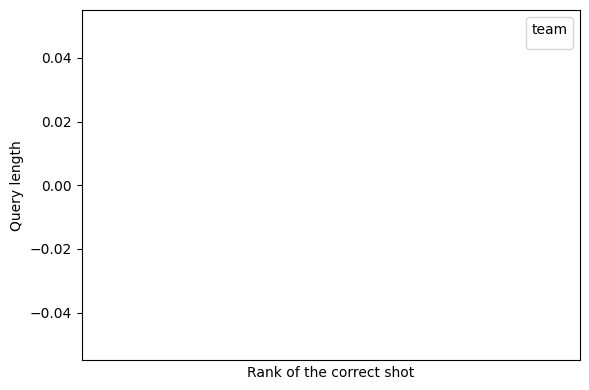

In [79]:
textData = dataset.loc[dataset["query_type"]=="CLIP"]
textData["rankCat"] = ">100"
textData.loc[(textData.rank_shot_margin_0 <= 100),"rankCat"] = "1-100"

fig,ax = plt.subplots(1,1, figsize=(6,4))
textDataWithLength = textData.loc[textData.QueryLen > -1] # just to be sure
hue_order = team_order

#sns.boxenplot(data=textDataWithLength,x="rankCat",y="QueryWords", hue="team", ax=ax, hue_order = hue_order)
sns.boxenplot(data=textDataWithLength,x="rankCat",y="QueryLen", hue="team", ax=ax, hue_order = hue_order)

#ax.set_xlabel("Rank of the correct shot")
ax.set_xlabel("Rank of the correct shot")
#ax.set_ylabel("Words per query")
ax.set_ylabel("Query length")
plt.tight_layout()
plt.savefig("kis_TextQueryLengthVsRanking.pdf")